In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)
session.close()

# Precipitation Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# identify measurement table's columns
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# my trip dates
start_trip = '2018-08-01'
end_trip = '2018-08-10'

# latest date
last = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

print(f"Latest Date: {last[0]}")

# Calculate the date 1 year ago from the last data point in the database
last_year = dt.datetime.strptime(last[0], '%Y-%m-%d')
one_year_ago = dt.date(last_year.year, last_year.month, last_year.day) - dt.timedelta(days=365)
print(f"Date 1 year from the last data point: {one_year_ago}")

Latest Date: 2017-08-23
Date 1 year from the last data point: 2016-08-23


In [13]:
# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, Measurement.prcp]
query = session.query(*sel)\
    .filter(Measurement.date >= one_year_ago).all()
# query

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
precip = pd.DataFrame(query, columns=['Date','Precipitation'])
precip = precip.dropna(how='any')
precip = precip.sort_values(["Date"], ascending=True)
precip = precip.set_index("Date")
precip

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.08


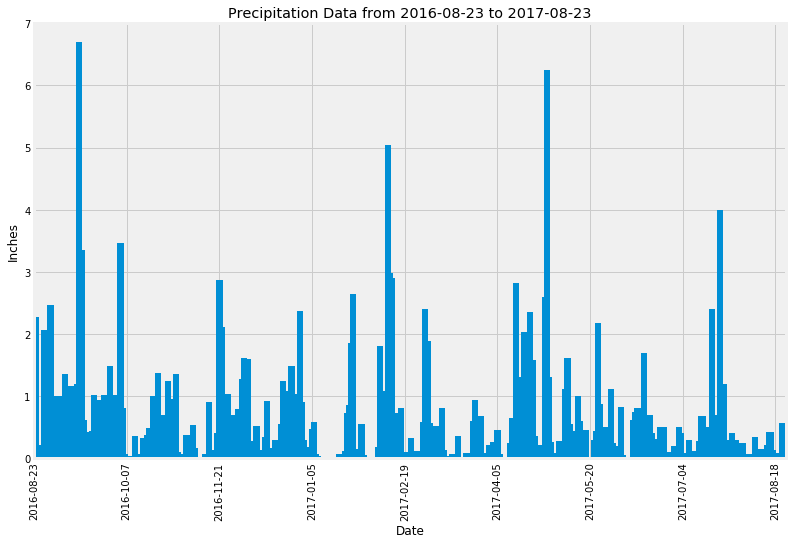

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
x_axis = precip.index.tolist()
y_axis = precip["Precipitation"].tolist()

plt.figure(figsize=(12,8))
plt.bar(x_axis, y_axis,width=3, label="Precipitation")
ticks = np.arange(0,400,45)
plt.xticks(ticks, rotation=90)
plt.xlim("2016-08-23","2017-08-23")
plt.ylim(0,7)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.title(f"Precipitation Data from {one_year_ago} to {last[0]}")
# plt.savefig("Images/precip.png")
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [16]:
# identify station table's columns
inspector = inspect(engine)
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [17]:
# Design a query to show how many stations are available in this dataset?
total = session.query(Station.station).count()
print(f"There are {total} stations availbale in this dataset.")

There are 9 stations availbale in this dataset.


In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel_count = [Measurement.station, func.count(Measurement.station)]
active = session.query(*sel_count)\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc()).all()
active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
data = session.query(func.min(Measurement.tobs),
                     func.max(Measurement.tobs),
                     func.avg(Measurement.tobs))\
             .filter(Measurement.station == active[0][0]).all()

print(f"Station {active[0][0]}'s lowest temperature recorded: {data[0][0]}F")
print(f"Station {active[0][0]}'s highest temperature recorded: {data[0][1]}F")
print(f"Station {active[0][0]}'s average temperature recorded: {round(data[0][2],2)}F")

Station USC00519281's lowest temperature recorded: 54.0F
Station USC00519281's highest temperature recorded: 85.0F
Station USC00519281's average temperature recorded: 71.66F


In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station
sel_t = [Measurement.date, Measurement.tobs]
query_t = session.query(*sel_t)\
    .filter(Measurement.date >= one_year_ago)\
    .filter(Measurement.station == active[0][0]).all()
# query_t

# Sort the dataframe by date
temp = pd.DataFrame(query_t, columns=['Date','Temperature'])
temp = temp.dropna(how='any')
temp = temp.sort_values(["Date"], ascending=True)
temp = temp.set_index("Date")
temp

,Temperature
Date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


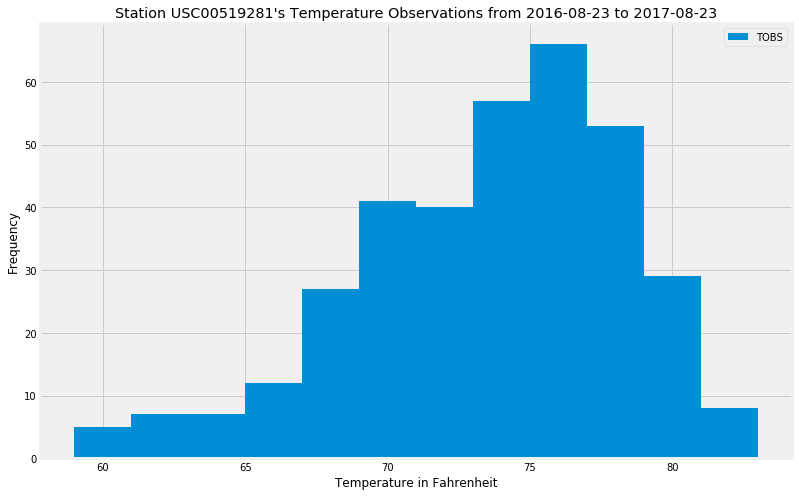

In [21]:
# Plot the results as a histogram
x = temp["Temperature"].tolist()

plt.figure(figsize=(12,8))
plt.hist(x, bins=12, label="TOBS")
plt.xlabel("Temperature in Fahrenheit")
plt.ylabel("Frequency")
plt.legend()
plt.title(f"Station {active[0][0]}'s Temperature Observations from {one_year_ago} to {last[0]}")
# plt.savefig("Images/hist.png")
plt.show()

## Bonus Challenge Assignment

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(f"My trip to Hawaii is from {start_trip} to {end_trip}")

previus_start = dt.datetime.strptime(start_trip, '%Y-%m-%d')
start_year_ago = dt.date(previus_start.year, previus_start.month, previus_start.day) - dt.timedelta(days=365)
# print(start_year_ago)

previus_end = dt.datetime.strptime(end_trip, '%Y-%m-%d')
end_year_ago = dt.date(previus_end.year, previus_end.month, previus_end.day) - dt.timedelta(days=365)
# print(end_year_ago)

print(f"The Min Temp for the previous year: {calc_temps(start_year_ago, end_year_ago)[0][0]} F")
print(f"The Avg Temp for the previous year: {round(calc_temps(start_year_ago, end_year_ago)[0][1],2)} F")
print(f"The Max Temp for the previous year: {calc_temps(start_year_ago, end_year_ago)[0][2]} F")

My trip to Hawaii is from 2018-08-01 to 2018-08-10
The Min Temp for the previous year: 71.0 F
The Avg Temp for the previous year: 79.03 F
The Max Temp for the previous year: 83.0 F


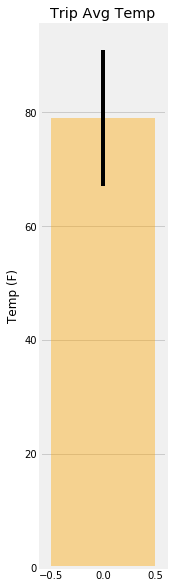

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tmin = calc_temps(start_year_ago, end_year_ago)[0][0]
tavg = calc_temps(start_year_ago, end_year_ago)[0][1]
tmax = calc_temps(start_year_ago, end_year_ago)[0][2]
y_err = tmax-tmin

plt.figure(figsize=(2,10))
plt.bar(0,tavg,yerr=y_err,align="center",width=1,color="orange",alpha=0.4)
plt.xlim(-0.6,0.6)
plt.ylim=(0,100)
plt.ylabel("Temp (F)")
plt.title("Trip Avg Temp")
plt.grid(which='major', axis='x', linestyle='')
plt.grid(which='major', axis='y', linestyle='-')
# plt.savefig("Images/temperature.png")
plt.show()

In [25]:
# Calculate the total amount of rainfall per weather station
# for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount
# and list the station, name, latitude, longitude, and elevation
sel_prcp = [Station.station,Station.name,Station.latitude,Station.longitude,
            Station.elevation,func.sum(Measurement.prcp)]
q_result = session.query(*sel_prcp)\
    .filter(Station.station == Measurement.station)\
    .group_by(Measurement.station)\
    .filter(Measurement.date >= start_year_ago)\
    .filter(Measurement.date <= end_year_ago)\
    .order_by(func.sum(Measurement.prcp).desc()).all()
  
stations_prcp = pd.DataFrame(q_result, columns=['Station','Name','Latitude','Longitude',
                                                'Elevation','Total Precipitation'])
stations_prcp

,Station,Name,Latitude,Longitude,Elevation,Total Precipitation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.92
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.32
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.06
3,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.04
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.00


In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [27]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
start_obj = dt.datetime.strptime(start_trip, '%Y-%m-%d')
end_obj = dt.datetime.strptime(end_trip, '%Y-%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date
trip_dates = []
normals =[]

while (start_obj <= end_obj):
    trip_dates.append(dt.datetime.strftime(start_obj,'%Y-%m-%d'))
    date_start = dt.datetime.strftime(start_obj,'%m-%d')
    normals.append(list(np.ravel(daily_normals(date_start))))
    start_obj = start_obj + dt.timedelta(days = 1)

normals

[[67.0, 75.54, 83.0],
 [68.0, 75.60377358490567, 84.0],
 [70.0, 76.61111111111111, 85.0],
 [69.0, 76.71153846153847, 84.0],
 [69.0, 76.14814814814815, 82.0],
 [67.0, 76.25, 83.0],
 [71.0, 77.15686274509804, 83.0],
 [68.0, 76.5576923076923, 83.0],
 [69.0, 75.98039215686275, 81.0],
 [65.0, 76.42, 83.0]]

In [28]:
# Load the previous query results into a Pandas DataFrame and
# add the `trip_dates` range as the `date` index
normals_results = pd.DataFrame(normals, columns=['tmin','tavg','tmax'])
normals_results['Date'] = trip_dates
normals_results = normals_results.set_index("Date")
normals_results

,tmin,tavg,tmax
Date,,,
2018-08-01,67.0,75.540000,83.0
2018-08-02,68.0,75.603774,84.0
2018-08-03,70.0,76.611111,85.0
2018-08-04,69.0,76.711538,84.0
2018-08-05,69.0,76.148148,82.0
2018-08-06,67.0,76.250000,83.0
2018-08-07,71.0,77.156863,83.0
2018-08-08,68.0,76.557692,83.0
2018-08-09,69.0,75.980392,81.0


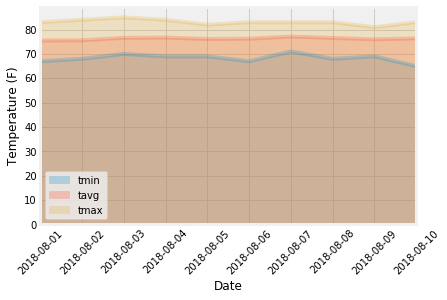

In [29]:
# Plot the daily normals as an area plot with `stacked=False`
normals_results.plot.area(stacked=False,alpha=0.25)
plt.xticks(rotation=45)
plt.ylabel("Temperature (F)")
# plt.savefig("Images/daily-normals.png")
plt.show()